In [132]:
from typing import List
import nltk
import os
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from enchant.checker import SpellChecker
# from nltk.stem import WordNetLemmatizer
import swifter
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

## Non dynamic learning rate 

In [209]:
import tensorflow.compat.v1 as tf
import numpy as np
from typing import List
import math

tf.disable_v2_behavior()
eps = 0.2 #1e-2

def save_loss(data: list, filename: str):
    with open(filename, 'w') as f:
        for item in data:
            f.write("%s\n" % item)


class LogisticRegression:
    def __init__(self, X_train: np.ndarray, y_train: np.ndarray,x_test: np.ndarray,y_test:np.ndarray,x_validation:np.ndarray, y_validation: np.ndarray, epoch=1000, learning_rate=0.0001, batch_size=200):
        """
        weighted logistic regression using cross entropy loss function
        :param num_iter:
        :param batch_size: -1 means all
        """
        self.losses = []
        self.test_loss = []
        self.valid_loss = []
        self.sess = tf.Session()
        features = X_train.shape[1]
        self.x = tf.placeholder(tf.float64, [None, features])
        y_train_variable = tf.placeholder(tf.float64, [None, 1])
        W = tf.Variable(tf.random.uniform([features, 1],dtype=tf.float64))
        b = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
        self.y = tf.add(tf.matmul(self.x, W), b)
        w1_weight = (y_train == 1).sum()    # for imbalance data
        w0_weight = (y_train == 0).sum()
        # pos_weight multiple the 1 label => targets * -log(sigmoid(logits)) * pos_weight 
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels= y_train_variable, 
            logits= tf.cast(self.y, tf.float64))) #, pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
        update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 
        self.sess.run(tf.global_variables_initializer())
        rows_num = X_train.shape[0]
        for i in range(0, epoch):
            for counter_step in range(0, rows_num//batch_size):
                X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
                Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
                Y_batch = Y_batch.reshape((Y_batch.size, 1))
                self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value_test = self.sess.run(loss, feed_dict={self.x:x_test, y_train_variable: y_test.reshape(y_test.size,1)})
            loss_value_validation = self.sess.run(loss, feed_dict={self.x:x_validation, y_train_variable: y_validation.reshape(y_validation.size,1)})
            print(f"iteration {i}: loss value is: {loss_value}")
            self.losses.append(loss_value)
            self.test_loss.append(loss_value_test)
            self.valid_loss.append(loss_value_validation)
        save_loss(self.losses, filename="train_error.txt")
        save_loss(self.test_loss, filename="test_error.txt")
        save_loss(self.valid_loss, filename="validation_error.txt")

    def predict(self, X_test, thr=0.4):
        predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions


## dynamic learning rate

In [183]:
# import tensorflow.compat.v1 as tf
# import numpy as np
# from typing import List
# import math

# tf.disable_v2_behavior()
# eps = 0.2 #1e-2

# def save_loss(data: list, filename: str):
#     with open(filename, 'w') as f:
#         for item in data:
#             f.write("%s\n" % item)


# class LogisticRegression:
#     def __init__(self, X_train: np.ndarray, y_train: np.ndarray,x_test: np.ndarray,y_test:np.ndarray,x_validation:np.ndarray, y_validation: np.ndarray, epoch=1000, learning_rate=0.0001, batch_size=200):
#         """
#         weighted logistic regression using cross entropy loss function
#         :param num_iter:
#         :param batch_size: -1 means all
#         """
#         self.losses = []
#         self.test_loss = []
#         self.valid_loss = []
#         self.sess = tf.Session()
#         lr = learning_rate
#         learning_rate_tensor = tf.placeholder(tf.float64, shape=[])  # tensor for implement dynamic learning rate 
#         features = X_train.shape[1]
#         self.x = tf.placeholder(tf.float64, [None, features])
#         y_train_variable = tf.placeholder(tf.float64, [None, 1])
#         W = tf.Variable(tf.random.uniform([features, 1],dtype=tf.float64))
#         b = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
#         self.y = tf.add(tf.matmul(self.x, W), b)
#         w1_weight = (y_train == 1).sum()    # for imbalance data
#         w0_weight = (y_train == 0).sum()
#         # pos_weight multiple the 1 label => targets * -log(sigmoid(logits)) * pos_weight 
#         loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels= y_train_variable, logits= tf.cast(self.y, tf.float64), 
#                                                             pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
# #         loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels= y_train_variable, logits= tf.cast(self.y, tf.float64))) #,pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
#         update = tf.train.GradientDescentOptimizer(learning_rate = learning_rate_tensor).minimize(loss) 
# #         update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 
#         self.sess.run(tf.global_variables_initializer())
#         rows_num = X_train.shape[0]
#         for i in range(0, epoch):
#             for counter_step in range(0, rows_num//batch_size):
#                 X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
#                 Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
#                 Y_batch = Y_batch.reshape((Y_batch.size, 1))
#                 self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch, learning_rate_tensor:lr})
#             loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
#             loss_value_test = self.sess.run(loss, feed_dict={self.x:x_test, y_train_variable: y_test.reshape(y_test.size,1)})
#             loss_value_validation = self.sess.run(loss, feed_dict={self.x:x_validation, y_train_variable: y_validation.reshape(y_validation.size,1)})
#             print(f"iteration {i}: loss value is: {loss_value}")
#             self.losses.append(loss_value)
#             self.test_loss.append(loss_value_test)
#             self.valid_loss.append(loss_value_validation)
#             if  self.losses[i] > self.losses[i-1]:  # check if the loss divergence
#                 print("=====change learning rate=========")
#                 lr = lr/10
#         save_loss(self.losses, filename="train_error.txt")
#         save_loss(self.test_loss, filename="test_error.txt")
#         save_loss(self.valid_loss, filename="validation_error.txt")

#     def predict(self, X_test, thr=0.5):
#         predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
#         predictions[predictions >= thr] = 1
#         predictions[predictions < thr] = 0
#         return predictions

# read and split the data 

In [135]:
from sklearn.utils import shuffle
df= pd.read_csv("../Data/ver1.csv", index_col=False)
df = df.dropna()
df = shuffle(df)
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)
X = df["Text"]
y= df["oh_label"]

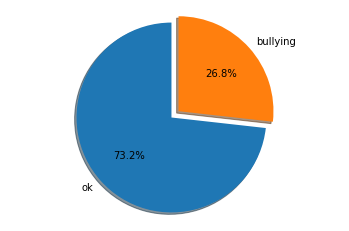

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y.value_counts(), explode=(0, 0.1), labels=["ok","bullying"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

In [184]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,stratify = y)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

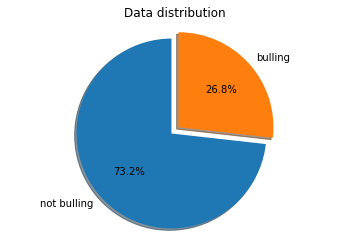

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y_train.value_counts(), explode = [0,0.1], labels=["not bulling", "bulling"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Data distribution")
plt.show()

In [186]:
label_0_weight = y.size / (y == 0).sum()
label_1_weight = y.size / (y == 1).sum()
label_1_weight,label_0_weight

(3.7353853049942103, 1.3655792104221005)

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

count_vect = CountVectorizer(min_df=0.001, lowercase=True,stop_words='english',preprocessor=preprocess_text) #max_features=1000
X_train_counts = count_vect.fit_transform(x_train)
x_train = pd.DataFrame(X_train_counts.toarray(), columns=count_vect.get_feature_names())

In [188]:
X_test_counts = count_vect.transform(x_test)
x_test = pd.DataFrame(X_test_counts.toarray(), columns=count_vect.get_feature_names())

In [189]:
X_validation_counts = count_vect.transform(x_validation)
x_validation = pd.DataFrame(X_validation_counts.toarray(), columns=count_vect.get_feature_names())

In [190]:
# from sklearn.utils import shuffle
# X_1 = pd.read_csv("../Data/log_1.csv", index_col=0)
# X_1 = shuffle(X_1)
# X_1 = X_1.loc[(X_1.sum(axis=1) != 0),:]
# X_1 = X_1.loc[(X_1.sum(axis=1) != 1),:]
# X_1 = X_1.loc[:,(X_1.sum(axis=0) != 0)]
# y = X_1["oh_label"]

In [191]:
from sklearn.preprocessing import StandardScaler
scaler_train = StandardScaler()
scaler_train.fit(x_train)
x_train = scaler_train.transform(x_train)
x_test = scaler_train.transform(x_test)
x_validation = scaler_train.transform(x_validation)

In [192]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# fig1, ax1 = plt.subplots()
# ax1.pie([70, 15, 15], explode = [0,0.1,0.1], labels=["train","test","validation"], autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal') 
# plt.show()

In [193]:
# X_1.drop("oh_label",axis=1, inplace = True)
# X = X_1

In [194]:
label_0_weight = y_train.size / (y_train == 0).sum()
label_1_weight = y_train.size / (y_test == 1).sum()
label_1_weight,label_0_weight

(17.356806347632034, 1.3655872024970737)

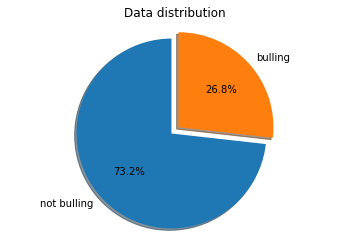

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y_train.value_counts(), explode = [0,0.1], labels=["not bulling", "bulling"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Data distribution")
plt.show()

In [196]:
# from sklearn.linear_model import SGDClassifier
# logmodel = SGDClassifier(max_iter=80,loss='log', class_weight= "balanced", random_state=42)
# logmodel.fit(x_train,y_train)
# predictions = logmodel.predict(x_test)
# print(classification_report(y_test,predictions,zero_division=0))
from collections import Counter
print(Counter(y_train))

Counter({0.0: 51260, 1.0: 18740})


In [197]:
# oversample implementation
# from imblearn.over_sampling import SMOTE

# from imblearn import under_sampling, over_sampling
# from imblearn.over_sampling import RandomOverSampler 
# oversample = RandomOverSampler(random_state=42,sampling_strategy=0.9)
# x_train, y_train = oversample.fit_resample(x_train, y_train)

In [198]:
label_0_weight = y_train.size / (y_train == 0).sum()
label_1_weight = y_train.size / (y_test == 1).sum()
label_1_weight,label_0_weight

(17.356806347632034, 1.3655872024970737)

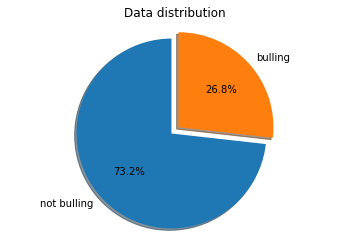

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y_train.value_counts(), explode = [0,0.1], labels=["not bulling", "bulling"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Data distribution")
plt.show()

In [200]:
from collections import Counter
print(Counter(y_train))

Counter({0.0: 51260, 1.0: 18740})


In [210]:
import seaborn as sns
logistic = LogisticRegression(x_train,y_train.values,x_test,y_test.values,x_validation, y_validation.values,epoch=80,learning_rate=0.01,batch_size=50)
predictions = logistic.predict(x_validation)
print(classification_report(y_validation, predictions))

iteration 0: loss value is: 1.8592386153886098
iteration 1: loss value is: 1.3688990952620355
iteration 2: loss value is: 1.0335733987222702
iteration 3: loss value is: 0.6691833620912003
iteration 4: loss value is: 0.5459389942488951
iteration 5: loss value is: 0.46893537320540696
iteration 6: loss value is: 0.4138771078205348
iteration 7: loss value is: 0.3754891868352466
iteration 8: loss value is: 0.3440714486808138
iteration 9: loss value is: 0.3215845827891004
iteration 10: loss value is: 0.30017162942568176
iteration 11: loss value is: 0.2868345365528745
iteration 12: loss value is: 0.2778934934359013
iteration 13: loss value is: 0.2703518383980846
iteration 14: loss value is: 0.2645392557544761
iteration 15: loss value is: 0.26094810556633696
iteration 16: loss value is: 0.256274929808723
iteration 17: loss value is: 0.2524037155491876
iteration 18: loss value is: 0.25031021072992277
iteration 19: loss value is: 0.2474309319804278
iteration 20: loss value is: 0.2455935967312300

0.8454666666666667

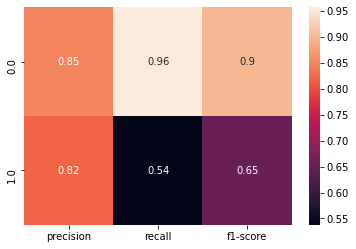

In [211]:
clf_report = classification_report(y_validation, predictions, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T, annot=True)
clf_report["accuracy"]

Text(33.0, 0.5, 'True label')

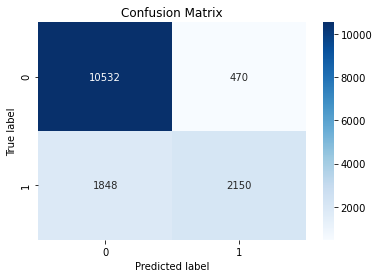

In [212]:
from sklearn.metrics import confusion_matrix
cc = confusion_matrix(y_validation, predictions, labels=[0, 1])
sns.heatmap(cc, annot=True, fmt="g", cmap='Blues')
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.ylabel("True label")

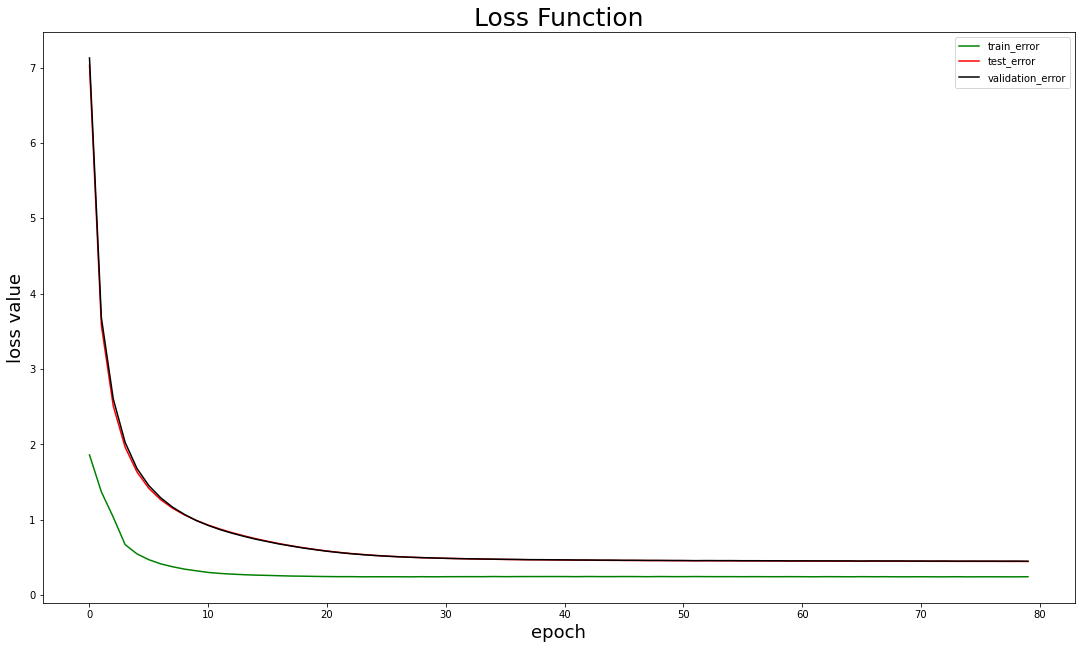

In [213]:
import matplotlib.pyplot as plt 
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
data_train = np.loadtxt("train_error.txt")
data_test = np.loadtxt("test_error.txt")
data_validation = np.loadtxt("validation_error.txt")
plt.plot(data_train,color='g',label='train_error')
plt.plot(data_test,color='r',label='test_error')
plt.plot(data_validation,color='k',label='validation_error')
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.legend()
plt.show()